What they do is replace every pixel that needs to be removed with a weighted average of it's neighbours. Since some of it's 
neighbours might also need to be removed, we get system of linear equations that we have to solve, to find the new values of the pixels we want to replace.

​

A custom single metric that is a combination of Least Relevant First and Most Relevant First:

(Least Relevant First - Most Relevant First) / 2, accross different thresholds.

In [6]:
import torch
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import io
import requests
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision.transforms as T

In [7]:
from road import ROADCombined

In [8]:
from EigenCAM import EigenCAM
from ScoreCAM import ScoreCAM
from AblationCAM import AblationCAM
from model_tragets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from functions import show_cam_on_image
import functions as func

In [9]:
# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("EigenCAM", EigenCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cg, attribution, use_rgb=True)
        print(name)
        print(score)
        print(" ")
        #visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


Resnet50 model and [model.layer4]

Identify Dog

EigenCAM
-9.1476795e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [04:34<00:00,  4.30s/it]


AblationCAM
-5.9853326e-05
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:16<00:00,  2.94s/it]


ScoreCAM
-3.5444682e-06
 


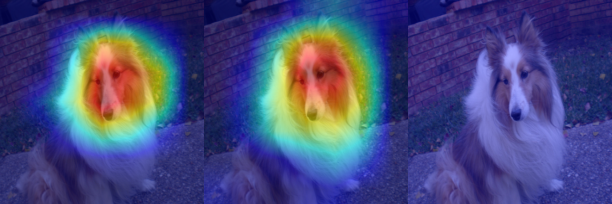

In [7]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

Identify Butterfly

EigenCAM
0.35377035
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [05:15<00:00,  4.92s/it]


AblationCAM
0.32565373
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:10<00:00,  2.89s/it]


ScoreCAM
-4.440546e-06
 


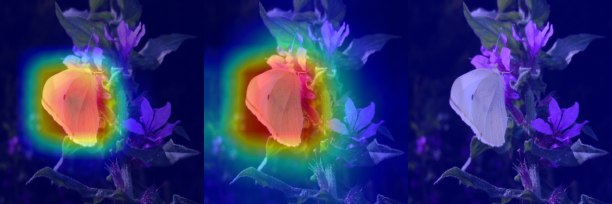

In [8]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

Identify Car

EigenCAM
0.31405407
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [05:19<00:00,  4.99s/it]


AblationCAM
0.3621794
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:03<00:00,  2.84s/it]


ScoreCAM
8.6426735e-07
 


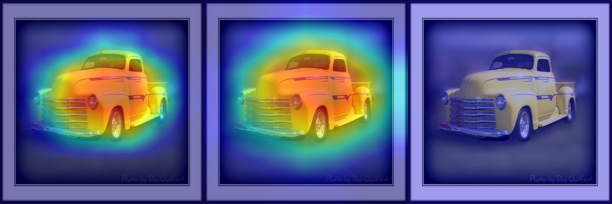

In [10]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

Identify bottle

EigenCAM
-0.00026981134
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [05:19<00:00,  5.00s/it]


AblationCAM
-1.9044164e-05
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:09<00:00,  2.89s/it]


ScoreCAM
2.3512985e-06
 


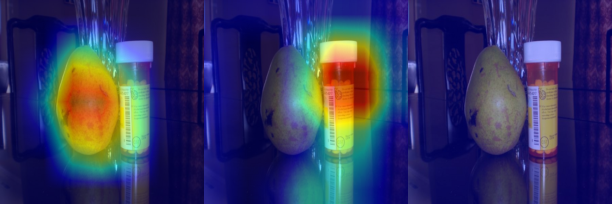

In [11]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

cat

EigenCAM
-0.0010394308
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [04:48<00:00,  4.51s/it]


AblationCAM
-0.00034512483
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [05:33<00:00,  2.61s/it]


ScoreCAM
1.4416764e-05
 


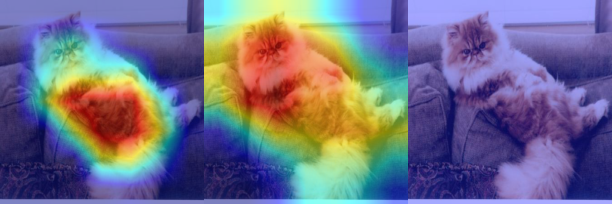

In [12]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet34 model and [model.layer4]

Dog

EigenCAM
-9.949368e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:42<00:00,  2.67s/it]


AblationCAM
-8.20852e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:52<00:00,  1.63s/it]


ScoreCAM
-1.7976708e-05
 


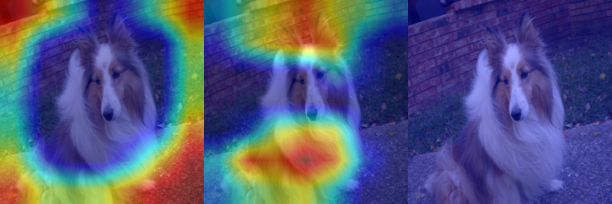

In [13]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

Butterfly

EigenCAM
-0.3128618
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.73s/it]


AblationCAM
0.32009768
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:51<00:00,  1.61s/it]


ScoreCAM
-3.784895e-06
 


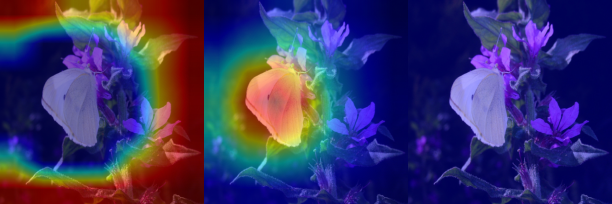

In [14]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

Identify Car

EigenCAM
-0.27221233
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.80s/it]


AblationCAM
0.3889919
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:54<00:00,  1.70s/it]


ScoreCAM
9.685755e-08
 


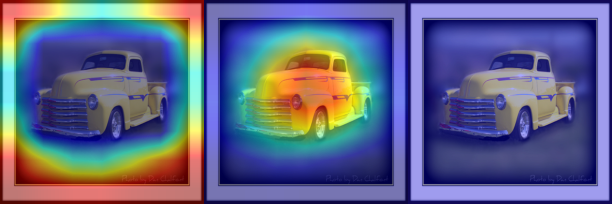

In [15]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

Bottle

EigenCAM
-4.667331e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.84s/it]


AblationCAM
0.00067815825
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.18it/s]


ScoreCAM
4.4755463e-05
 


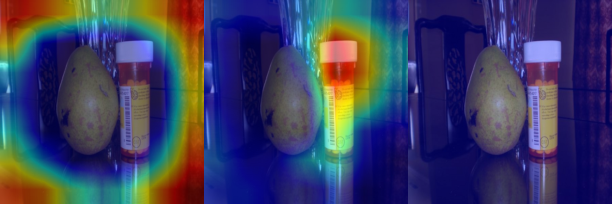

In [16]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

Cat

EigenCAM
-0.0012291525
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.44s/it]


AblationCAM
-0.004606952
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:28<00:00,  1.12it/s]


ScoreCAM
-0.0029156934
 


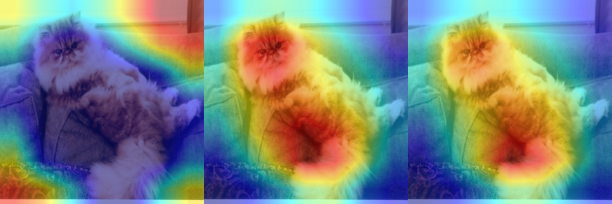

In [17]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet50 model and [model.layer3]

predicting dog from the image

EigenCAM
-3.4249322e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:27<00:00,  2.75s/it]


AblationCAM
-8.869318e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:02<00:00,  2.86s/it]


ScoreCAM
-2.5259942e-06
 


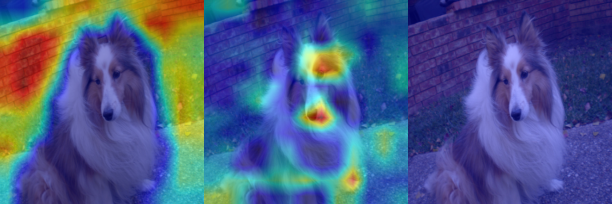

In [18]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting butterfly from the image

EigenCAM
-0.2891839
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:42<00:00,  3.21s/it]


AblationCAM
-0.011517167
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:20<00:00,  2.20s/it]


ScoreCAM
0.23059842
 


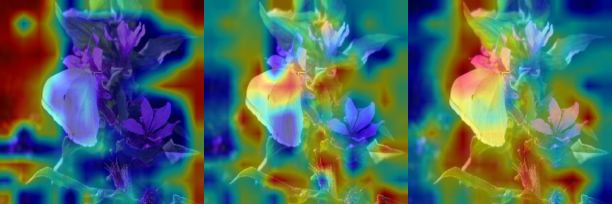

In [19]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

predicting car from the image

EigenCAM
-0.19978906
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:40<00:00,  3.14s/it]


AblationCAM
-0.25235176
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:43<00:00,  2.56s/it]


ScoreCAM
1.8775463e-06
 


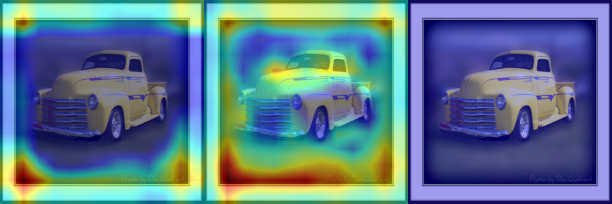

In [20]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

predicting bottle from the image

EigenCAM
8.094075e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:22<00:00,  2.57s/it]


AblationCAM
-8.509349e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:46<00:00,  2.59s/it]


ScoreCAM
8.018833e-06
 


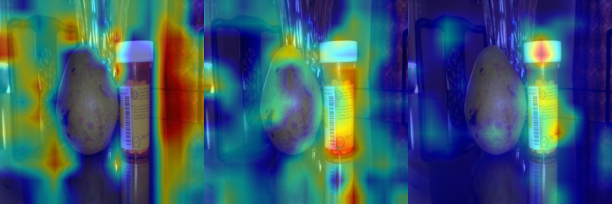

In [21]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

predicting cat from the image

EigenCAM
8.4085346e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:28<00:00,  2.77s/it]


AblationCAM
-3.0674884e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:01<00:00,  2.84s/it]


ScoreCAM
-1.13507485e-05
 


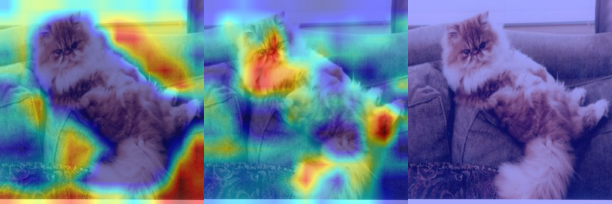

In [22]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet34 model and [model.layer3]

predicting dog from the image

EigenCAM
-0.0002239997
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.36s/it]


AblationCAM
-0.00012160957
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


ScoreCAM
-6.0492566e-06
 


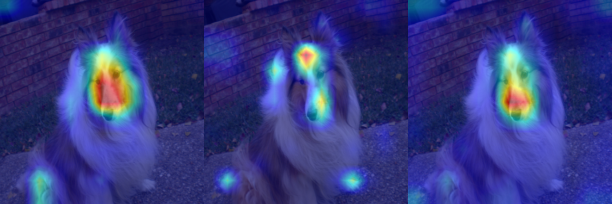

In [10]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting butterfly from the image

EigenCAM
0.336326
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.36s/it]


AblationCAM
0.2402052
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it]


ScoreCAM
0.29792318
 


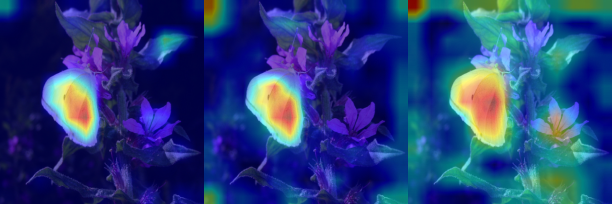

In [11]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

predicting car from the image

EigenCAM
-0.3290222
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.39s/it]


AblationCAM
0.3891313
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.71s/it]


ScoreCAM
-2.644956e-07
 


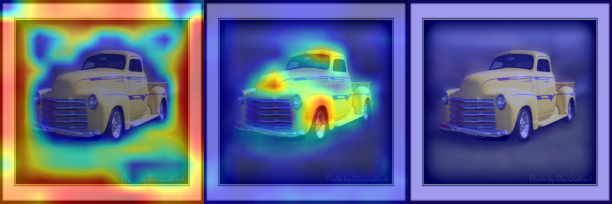

In [12]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

predicting bottle from the image

EigenCAM
-0.0010712835
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.42s/it]


AblationCAM
0.00077275734
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.71s/it]


ScoreCAM
1.0635413e-05
 


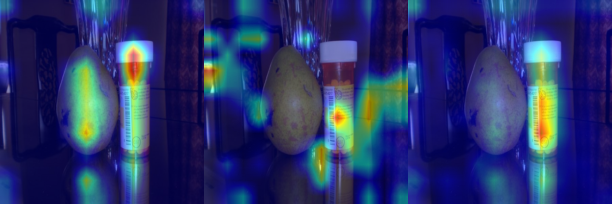

In [13]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

predicting cat from the image

EigenCAM
-7.383898e-05
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.42s/it]


AblationCAM
-0.00083787367
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.71s/it]


ScoreCAM
0.0003655143
 


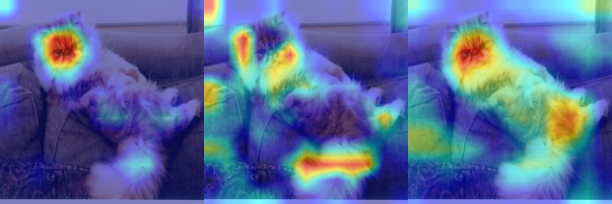

In [15]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

densenet121 and denseblock4 layer

predicting dog from the image

EigenCAM
-1.6856615e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:40<00:00,  5.01s/it]


AblationCAM
-1.5647875e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:44<00:00,  2.57s/it]


ScoreCAM
-5.9029186e-05
 


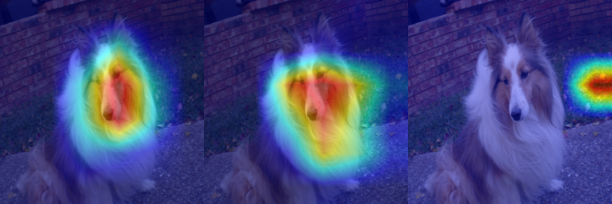

In [16]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting butterfly from the image

EigenCAM
0.39406544
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:40<00:00,  5.01s/it]


AblationCAM
0.34711263
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:45<00:00,  2.59s/it]


ScoreCAM
0.37406012
 


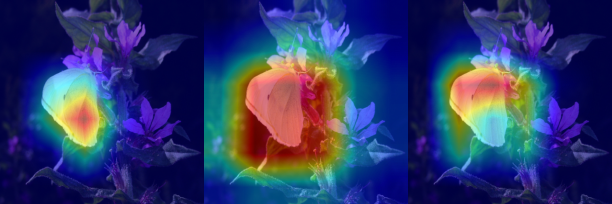

In [17]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

predicting car from the image

EigenCAM
0.39248067
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:39<00:00,  4.98s/it]


AblationCAM
0.3525718
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:47<00:00,  2.61s/it]


ScoreCAM
0.020337433
 


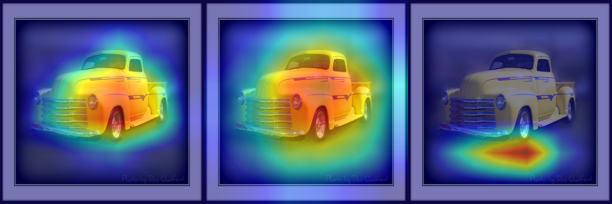

In [18]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

predicting bottle from the image

EigenCAM
-0.00084982294
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:39<00:00,  4.97s/it]


AblationCAM
0.00031388845
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [18:53<00:00, 17.71s/it]


ScoreCAM
-0.0011059487
 


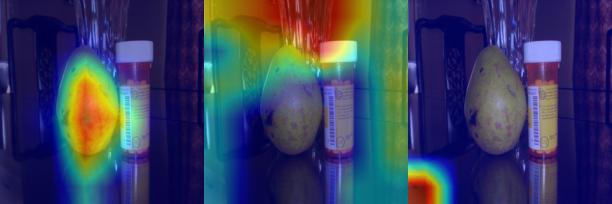

In [19]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

predicting cat from the image

EigenCAM
-0.00023877912
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:38<00:00,  4.94s/it]


AblationCAM
7.398581e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:44<00:00,  2.56s/it]


ScoreCAM
0.0008698065
 


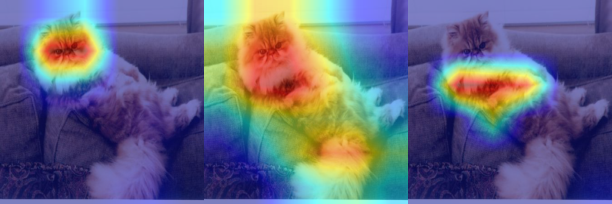

In [20]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

densenet121 and denseblock3 layer

predicting dog from the image

EigenCAM
-2.6527981e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:32<00:00,  4.76s/it]


AblationCAM
-2.083351e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:51<00:00,  2.68s/it]


ScoreCAM
-3.130488e-05
 


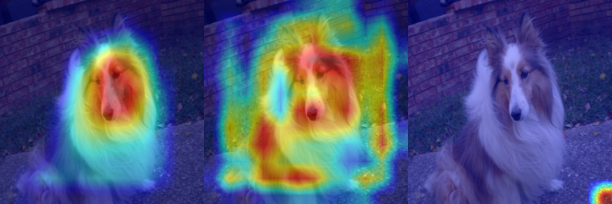

In [21]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000003.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting butterfly from the image

EigenCAM
-0.054262295
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:33<00:00,  4.79s/it]


AblationCAM
0.36669272
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:44<00:00,  2.58s/it]


ScoreCAM
-2.4437904e-06
 


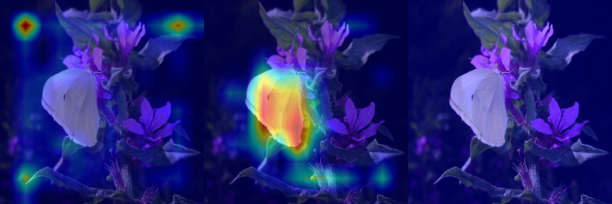

In [22]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

predicting car from the image

EigenCAM
-0.1725341
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:34<00:00,  4.82s/it]


AblationCAM
0.36653984
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:46<00:00,  2.60s/it]


ScoreCAM
0.00017464161
 


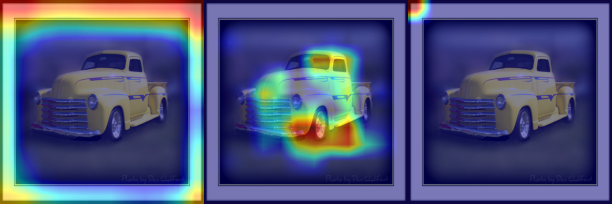

In [23]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=468)

predicting bottle from the image

EigenCAM
-0.00080385956
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:31<00:00,  4.73s/it]


AblationCAM
-0.0010332152
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:46<00:00,  2.61s/it]


ScoreCAM
4.816102e-07
 


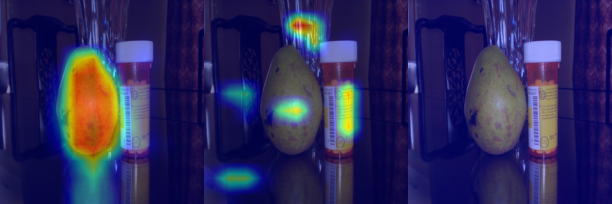

In [24]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000112.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=898)

predicting cat from the image

EigenCAM
-0.00016500932
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:32<00:00,  4.76s/it]


AblationCAM
0.0005806116
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:49<00:00,  2.65s/it]


ScoreCAM
0.00030482246
 


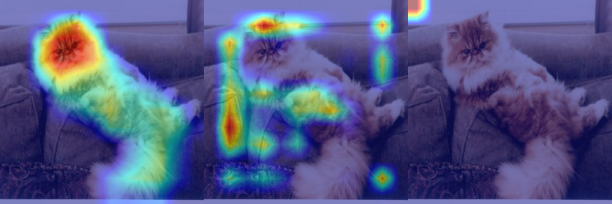

In [25]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)